# Imports

In [1]:
import os
from typing import List, Tuple

import pandas as pd
import numpy as np
import sklearn.preprocessing
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
import matplotlib.pyplot as plt
import matplotlib.patches
from minisom import MiniSom as SOM
from sklearn.svm import OneClassSVM

print("Libraries imported.")

Libraries imported.


# Constants

In [2]:
DATA_DIRECTORY = r"C:\Users\Daniel\Documents\Studium\7. Semester (WS 2020.21)\Seminar Data Mining in der Produktion\Gruppenarbeit\Data"
NORMALIZATION_NORM = "l2"
TEST_TRAIN_SPLIT = 0.1
RANDOM_SEED = 1     # for reproducibility
WINDOW = 300    # rolling window to smoothen plots

EXPERIMENT_NAMES = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

# Components
COMPONENTS = [
    ['A_1', 'A_2', 'A_3', 'A_4', 'A_5'],
    ['B_1', 'B_2', 'B_3', 'B_4', 'B_5'],
    ['C_1', 'C_2', 'C_3', 'C_4', 'C_5'],
    ['L_1', 'L_2'],
    ['L_3', 'L_6'],
    ['L_4', 'L_5'],
    ['L_7', 'L_8'],
    ['L_9', 'L_10']
]

L_cols = ['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
A_cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5']
B_cols = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5']
C_cols = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']
column_groups = [L_cols, A_cols, B_cols, C_cols]

COLORMAP = {
    "L_2": "b",
    "L_6": "g",
    "L_8": "r",
    "L_10": "c",
    "A_5": "m",
    "B_4": "y",
    "B_5": "k",
    "C_5": "tab:orange"
}

print("Constants set.")

Constants set.


# Utility functions

In [3]:
def load_data(directory: str):
    _filepaths = [directory + "/" + filename for filename in os.listdir(directory)]

    files = [pd.read_csv(path) for path in _filepaths]

    # Merge C13-1 and C13-2 as well as C7-1 and C7-2
    c13 = pd.concat([files[1], files[2]])
    c7 = pd.concat([files[6], files[7]])

    files[1] = c13
    files[6] = c7

    files.pop(2)
    files.pop(7)

    # Drop Timestamp column
    files = [df.drop("Timestamp", axis=1) for df in files]

    # Handle NaN
    files = [df.dropna() for df in files]

    return files


def normalize_files(files: List[pd.DataFrame], normalization_norm: str):
    column_names = files[0].columns
    files = [sklearn.preprocessing.normalize(df, norm=normalization_norm) for df in files]
    files = [pd.DataFrame(array, columns=column_names) for array in files]

    return files


def test_train_split(files: List[pd.DataFrame], split: float) -> Tuple[List[pd.DataFrame], List[pd.DataFrame]]:
    # Split train and test data -> first x% taken (not randomly)
    def split_df_not_randomly(df, split: float):
        split_index = int(len(df) * split)
        return df[:split_index], df[split_index:]

    train_files, test_files = zip(*[split_df_not_randomly(df, split) for df in files])

    return train_files, test_files


def plot_all_experiments(datasets: list, experiment_names: list, test_train_split: float = None,
                         savefig: str = "C:/Users/Daniel/Desktop/plot.png", ols_line: bool = False) -> None:
    fig, ax = plt.subplots(8, 1)
    fig.set_size_inches(6, 24)

    for i, dataset in enumerate(datasets):
        axis = ax[i]
        axis.scatter(x=dataset.index, y=dataset[0], s=1)
        axis.set_title(f"Experiment No. {experiment_names[i]}")

        if test_train_split is not None:    # plot vertical line
            test_train_split_index = int(len(dataset) * test_train_split)
            axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

        if ols_line:
            x = sm.add_constant(dataset.index)
            y = dataset[0]
            abline_plot(model_results=sm.OLS(y, x).fit(), ax=axis, color="black", linewidth=1)

        axis.set_ylim(bottom=0.0)   # plot only outliers (decision_function <= 0 umgedreht durch -1 oben)

    plt.tight_layout()

    if savefig:
        plt.savefig(savefig)
    plt.show()


print("Utils imported.")

Utils imported.


# Load and preprocess data

In [13]:
files = load_data(directory=DATA_DIRECTORY)

# Data normalization
#files = normalize_files(files, normalization_norm=NORMALIZATION_NORM)

# Feature selection
cols_to_include = ["L_2", "L_6", "L_8", "L_10", "A_5", "B_4", "B_5", "C_5"]  # regression: threshold 0.6
files = [file[cols_to_include] for file in files]

# Test-train split
train_files, test_files = test_train_split(files, split=TEST_TRAIN_SPLIT)

print("Loaded and preprocessed data.")

Loaded and preprocessed data.


# SOM

In [14]:
SOM_MAP_X_DIMENSION = 50      # 50 as taken from research paper
SOM_MAP_Y_DIMENSION = 50     # 50 as taken from research paper
SOM_TRAINING_EPOCHS = 10000

def train_model(training_data):
    model = SOM(x=SOM_MAP_X_DIMENSION, y=SOM_MAP_Y_DIMENSION, input_len=training_data.shape[1], random_seed=RANDOM_SEED)
    model.train(training_data, num_iteration=SOM_TRAINING_EPOCHS, verbose=True)
    return model

models = [train_model(train.to_numpy()) for train in train_files]

print("SOM models trained.")

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.0617004807705475
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.2897011175334008
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.417479247588986
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.0157642400410576
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.6320458796447266
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.4096234413698494
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.11904314506329
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.3371887356986223
SOM models trained.


### SOM: Activation on training data (above) and test data (below)

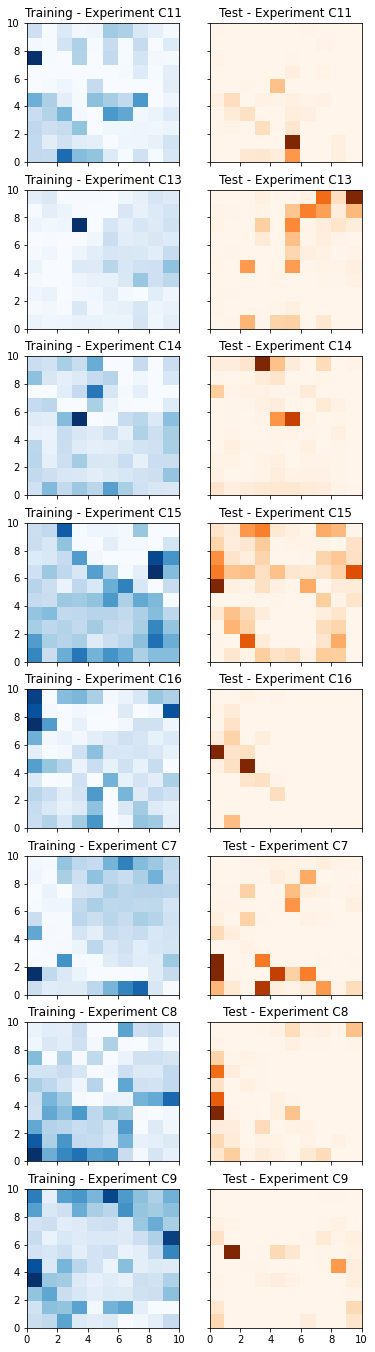

In [40]:
fig, ax = plt.subplots(8, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 24)

for i, test_file in enumerate(test_files):
    frequencies = models[i].activation_response(train_files[i].to_numpy())
    ax[i, 0].pcolor(frequencies.T, cmap='Blues')
    ax[i, 0].set_title(f"Training - Experiment {EXPERIMENT_NAMES[i]}")

    frequencies = models[i].activation_response(test_file.to_numpy())
    ax[i, 1].pcolor(frequencies.T, cmap='Oranges')
    ax[i, 1].set_title(f"Test - Experiment {EXPERIMENT_NAMES[i]}")

plt.show()

### SOM: Plot quantization errors

In [15]:
%%time
converted_files = [[file[i:i+1].to_numpy() for i in range(len(file) - 1)] for file in files]    # always grab two data points and convert them to numpy (two needed because MiniSom will not evaluate a single one)

quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_files[j]])
                       for j, model in enumerate(models)]

rolling_medians_som = [qe.rolling(WINDOW).median() for qe in quantization_errors]

print("Quantization errors computed.")

Quantization errors computed.
Wall time: 6min 21s


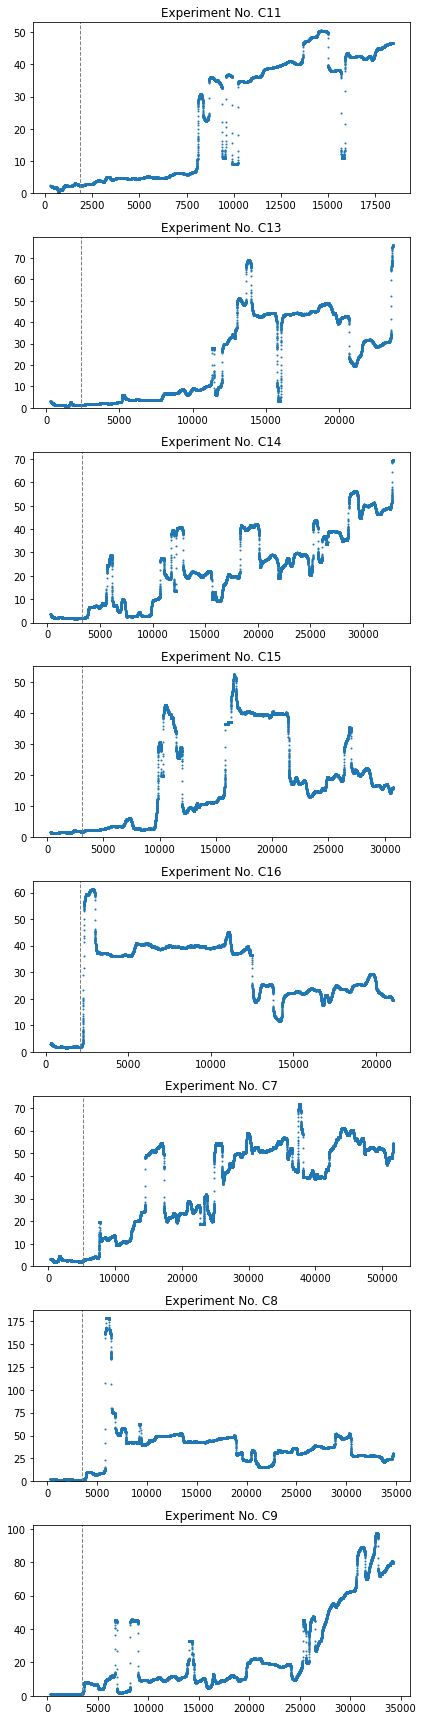

In [16]:
plot_all_experiments(rolling_medians_som, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig=f"C:/Users/Daniel/Desktop/som_final_qerror_50x50_10000epochs_noNorm.png")

### SOM: Anomaly Localization

In [17]:
%%time
def get_bmu_weights(model, row: pd.Series) -> np.ndarray:
    """Weights of Best Matching Unit"""
    return model._weights[model.winner(row.to_numpy())]
    
def most_diverging_feature(x: pd.Series, bmu_weights: np.ndarray) -> str:
    return (x - bmu_weights).abs().idxmax()

som_anom_loc = [[most_diverging_feature(row, get_bmu_weights(models[i], row))
                 for index, row in file.iterrows()]
                for i, file in enumerate(files)]

colors_som_anom_loc = [[COLORMAP[el] for el in file] for file in som_anom_loc]
                           
print("Computed SOM Anomaly localization.")

Computed SOM Anomaly localization.
Wall time: 2min 40s


<ipython-input-18-b0035e964d15>:5: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]


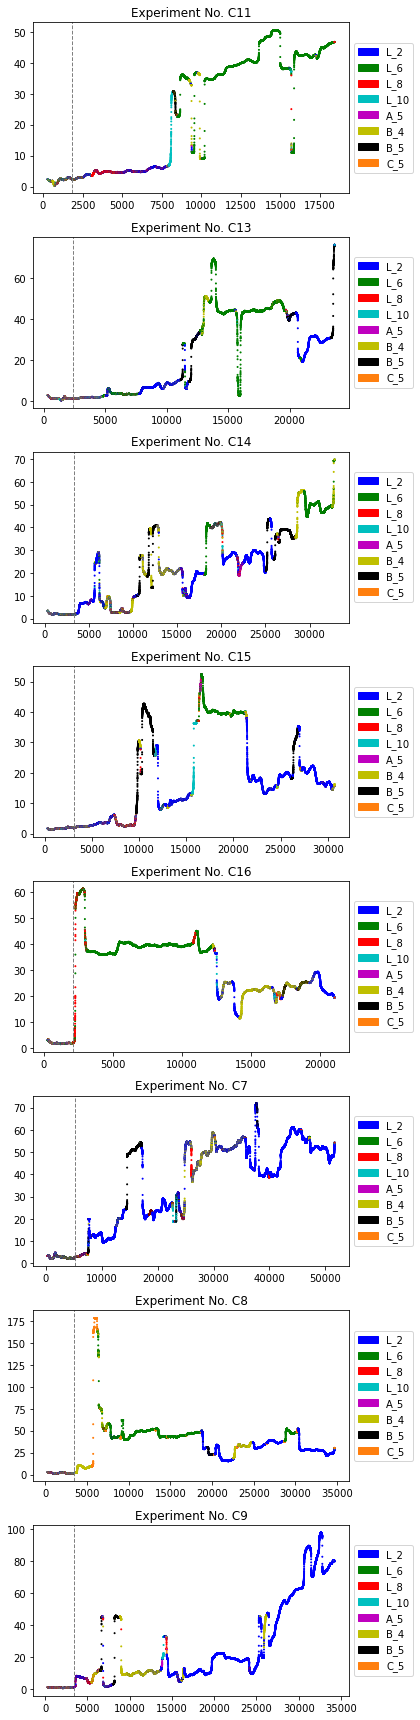

In [18]:
# Plot
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]

for i, dataset in enumerate(files):
    axis = ax[i]
    axis.scatter(x=rolling_medians_som[i].index, y=rolling_medians_som[i], c=colors_som_anom_loc[i][:-1], s=1)
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    # Add test_train_split line
    test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)
    
    # Add legend
    axis.legend(handles=patches, loc="center right", bbox_to_anchor=(1.22, 0.5))

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/SOM_final_anom_loc_50x50_10000epochs_noNorm.png")
plt.show()

# OneClass SVM

In [19]:
%%time
SVM_KERNEL = "rbf"
SVM_NU = 0.01

models_svm = [OneClassSVM(kernel=SVM_KERNEL, nu=SVM_NU).fit(train) for train in train_files]
predictions_svm = [pd.DataFrame(model.decision_function(files[i])) for i, model in enumerate(models_svm)]

rolling_medians = [-1 * pred.rolling(WINDOW).median() for pred in predictions_svm]  # multiply with -1 so that plot has same orientation as SOM plot

print("OneClassSVM models fitted.")

OneClassSVM models fitted.
Wall time: 437 ms


### OneClassSVM: Deviation

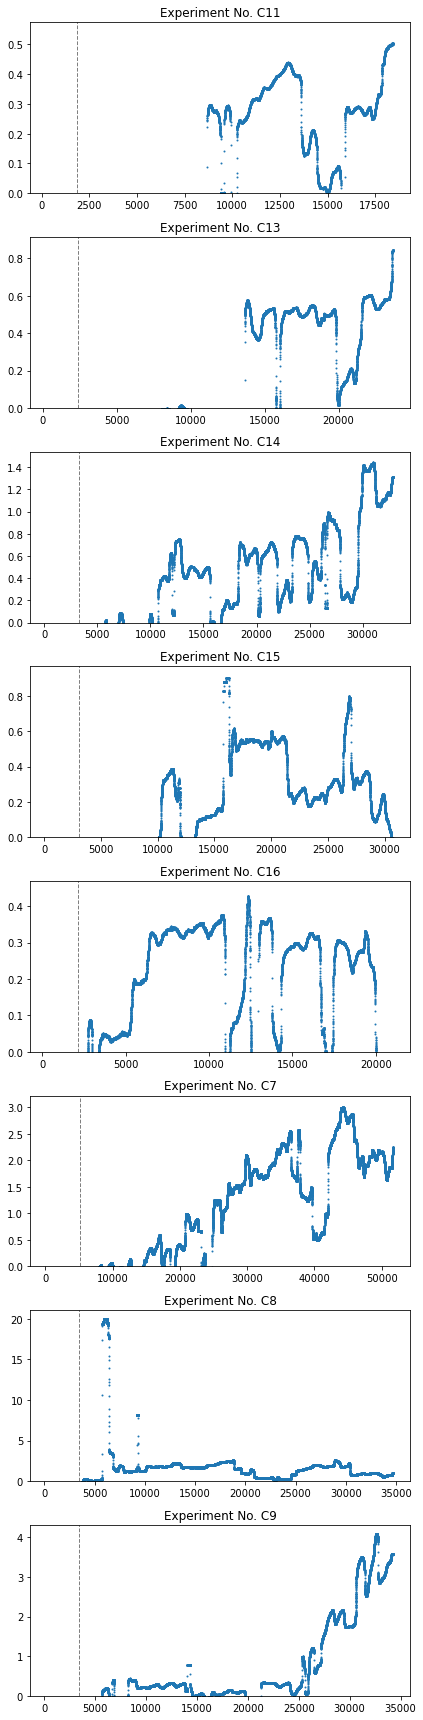

In [20]:
plot_all_experiments(rolling_medians, EXPERIMENT_NAMES, TEST_TRAIN_SPLIT,
                     ols_line=True, savefig="C:/Users/Daniel/Desktop/SVM_final_deviation_noNorm.png")

### OneClassSVM: Anomaly Localization

In [21]:
%%time
def get_bmu(x: pd.Series, model: OneClassSVM) -> np.ndarray:
    support_vectors = model.support_vectors_
    distances = np.linalg.norm(support_vectors - x.to_numpy(), axis=1)
    min_index = pd.Series(distances).idxmin()

    return support_vectors[min_index]

def most_diverging_feature(x: pd.Series, model: OneClassSVM) -> str:
    bmu = get_bmu(x, model)
    return (x - bmu).abs().idxmax()

oc_svm_anom_loc = [[most_diverging_feature(row, models_svm[i])
                          for index, row in file.iterrows()]
                         for i, file in enumerate(files)]

colors_oc_svm_anom_loc = [[COLORMAP[el] for el in file] for file in oc_svm_anom_loc]

print("Computed OneClassSVM Anomaly localization.")

Computed OneClassSVM Anomaly localization.
Wall time: 2min 16s


<ipython-input-22-34f2853880da>:5: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]


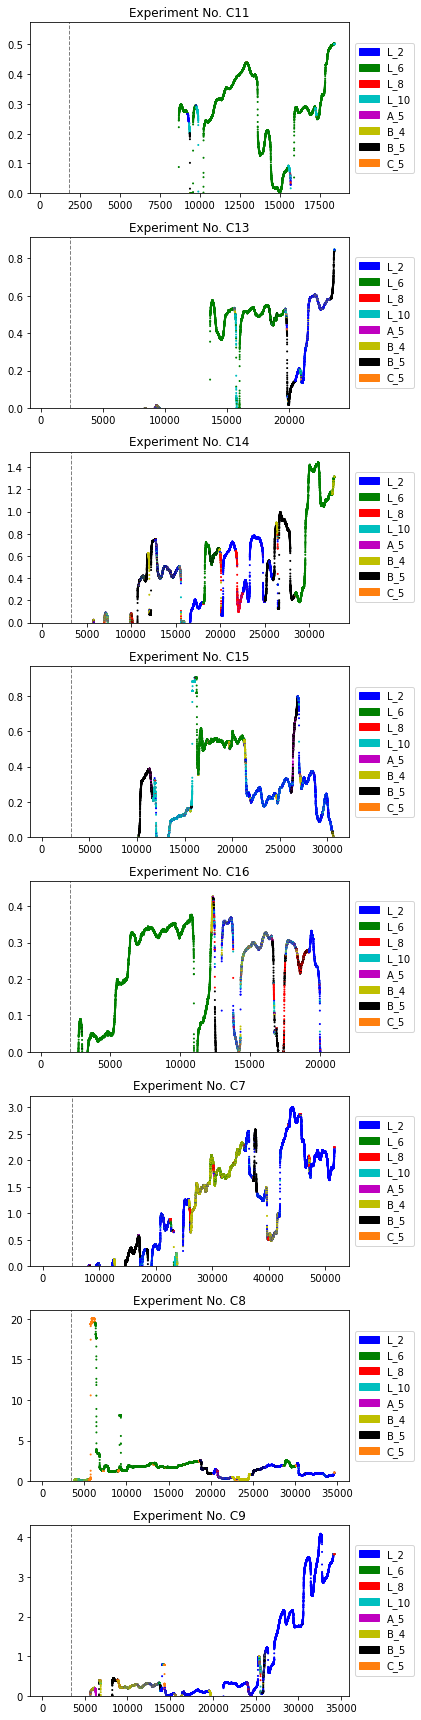

In [22]:
# Plot
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]

for i, dataset in enumerate(files):
    axis = ax[i]
    axis.scatter(x=rolling_medians[i].index, y=rolling_medians[i], c=colors_oc_svm_anom_loc[i], s=1)
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    # Add test_train_split line
    test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

    # Add legend
    axis.legend(handles=patches, loc="center right", bbox_to_anchor=(1.22, 0.5))
    axis.set_ylim(bottom=0.0)   # plot only outliers (decision_function <= 0 umgedreht durch -1 oben)

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/SVM_final_anom_loc_noNorm.png")
plt.show()

#### Anomaly localization as stackplot

In [ ]:
%%time
def set_others_na(l, value: str) -> list:
    return [(el if el == value else np.NaN) for el in l]

WINDOW = 300

occurrences_all = [
    [
        pd.Series(set_others_na(experiment, "L_2")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_6")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_8")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_10")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "A_5")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "B_4")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "B_5")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "C_5")).rolling(WINDOW).count() / WINDOW
    ] for experiment in oc_svm_anom_loc
]

print("Occurrences computed.")

In [ ]:
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

for i, experiment in enumerate(occurrences_all):
    axis = ax[i]
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    index = list(range(len(experiment[0])))
    axis.stackplot(index, *occurrences_all[i],
                   labels=COLORMAP.keys(),
                   colors=COLORMAP.values())

    # Add test_train_split line
    test_train_split_index = int(len(experiment[0]) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

    axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5))
    axis.set_ylim([0, 1])

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/SVM_final_anom_loc_stackplot.png")
plt.show()